## Decitabine treatment RNA-Seq time-series experiments
In order to test for any differences over multiple time points, once can use a design including the time factor, and then test using the **likelihood ratio test (LRT)**. Here, as we have control (DMSO) and treatment (Decitabine) time series, design formula containing the condition factor, the time factor, and the interaction of the two. In this case, using the likelihood ratio test with a reduced model which does not contain the interaction terms will test whether the condition induces a change in gene expression at any time point after the reference level time point (time 0). 

(see [this](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#time-series-experiments)  OR [this](http://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#time-course-experiments) for more details about DESeq2 time series experiments)


In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
suppressMessages(suppressWarnings(library (GenomicFeatures)))
suppressMessages(suppressWarnings(library (tximport)))
suppressMessages(suppressWarnings(library (tidyverse)))
suppressMessages(suppressWarnings(library (ggplot2)))
suppressMessages(suppressWarnings(library (ggrepel)))
suppressMessages(suppressWarnings(library (DESeq2)))
suppressMessages(suppressWarnings(library (patchwork)))
suppressMessages(suppressWarnings(library (BiocParallel)))

register(MulticoreParam(18))

plot_Save <- function (p, name_it){
    ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', dpi = 300)
    ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', dpi = 300)
}

## Pre-processing 

I'm mapping `hg38/gencode.v34` to the `fastq` files using salmon. 

Raw samples:

In [4]:
ls ../hl60-fastq/*fastq.gz

../hl60-fastq/120h_DMSO_rep1.fastq.gz*
../hl60-fastq/120h_DMSO_rep2.fastq.gz*
../hl60-fastq/120h_treated_rep1.fastq.gz*
../hl60-fastq/120h_treated_rep2.fastq.gz*
../hl60-fastq/6h_DMSO_rep1.fastq.gz*
../hl60-fastq/6h_DMSO_rep2.fastq.gz*
../hl60-fastq/6h_treated_rep1.fastq.gz*
../hl60-fastq/6h_treated_rep2.fastq.gz*
../hl60-fastq/72h_DMSO_rep1.fastq.gz*
../hl60-fastq/72h_DMSO_rep2.fastq.gz*
../hl60-fastq/72h_treated_rep1.fastq.gz*
../hl60-fastq/72h_treated_rep2.fastq.gz*


Alignment script:

In [5]:
cat ../salmon.sh

cat: ../salmon.sh: No such file or directory


In [6]:
# %%bash 
# nohup bash ~/Workflows/my_scripts/salmon.sh \
# ~/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-exp \
# ~/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-fastq \
# ~/genomes/hg38/gencode.v34/salmon_index/ > hl60-salmon.out&

Load annotations

In [7]:
%%R
GTF = '/rumi/shams/abe/genomes/hg38/gencode.v34/gencode.v34.annotation.gtf'
gtf <- rtracklayer::import(GTF)
gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')

txdb  = makeTxDbFromGFF(GTF,organism='Homo sapiens')
# tx2gene objects 
k <- keys(txdb, keytype = "TXNAME")
tx2gene <- AnnotationDbi::select(txdb, k, "GENEID", "TXNAME")

R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK

R[write to console]: 'select()' returned 1:1 mapping between keys and columns



In [8]:
%%R 
tx2name <- gtf[gtf$type == "transcript"] %>% data.frame %>% column_to_rownames('transcript_id') %>% dplyr::select('transcript_name')

import salmon quants:

In [9]:
%%R
files <- list.files(path='./quants', pattern="quant.sf",full.names = TRUE, recursive=T)
names(files) <- gsub("./quants/(\\S+)/quant.sf","\\1",files)

txi <- tximport(files, type = "salmon", tx2gene = tx2gene, txOut=T)

txi.gene <- summarizeToGene(txi, tx2gene, ignoreAfterBar= TRUE)

R[write to console]: reading in files with read_tsv

R[write to console]: 1 
R[write to console]: 2 
R[write to console]: 3 
R[write to console]: 4 
R[write to console]: 5 
R[write to console]: 6 
R[write to console]: 7 
R[write to console]: 8 
R[write to console]: 9 
R[write to console]: 10 
R[write to console]: 11 
R[write to console]: 12 
R[write to console]: 

R[write to console]: summarizing abundance

R[write to console]: summarizing counts

R[write to console]: summarizing length



Define the sample sheet

In [10]:
%%R 
# meta 
treats  <- rep(c(rep('DMSO',2), rep('treated',2)),3)
reps    <- rep(c('rep1','rep2'),6)
hours   <- c(rep('120h',4),rep('6h',4),rep('72h',4))
colData <- data.frame(
    time=hours, 
    cond=treats, 
    sample_id=paste(hours, treats, reps, sep='_'),
    row.names=colnames(txi$abundance)
)
colData

                  time    cond         sample_id
120h_DMSO_rep1    120h    DMSO    120h_DMSO_rep1
120h_DMSO_rep2    120h    DMSO    120h_DMSO_rep2
120h_treated_rep1 120h treated 120h_treated_rep1
120h_treated_rep2 120h treated 120h_treated_rep2
6h_DMSO_rep1        6h    DMSO      6h_DMSO_rep1
6h_DMSO_rep2        6h    DMSO      6h_DMSO_rep2
6h_treated_rep1     6h treated   6h_treated_rep1
6h_treated_rep2     6h treated   6h_treated_rep2
72h_DMSO_rep1      72h    DMSO     72h_DMSO_rep1
72h_DMSO_rep2      72h    DMSO     72h_DMSO_rep2
72h_treated_rep1   72h treated  72h_treated_rep1
72h_treated_rep2   72h treated  72h_treated_rep2


## PCA
Initial principal component analysis (PCA) shows the second treated biological replicate at 72h time point, behaves as an outlier. Removing that from the analysis give us a better representation of our dataset. In the second PCA plot, we can see that treated samples at 6h cluster with the non-treated samples which suggest that 6 hours treatment with the drug is not as effective as 72h and 120h. Although, we will check the variant genes in this time-point in the following statistical analysis.


In [11]:
%%R
plot_PCA <- function(vsd, colData=colData, gr=c('time', 'cond'), title=''){
    z <- plotPCA(vsd,intgroup=gr, returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca <- ggplot(z, aes(PC1, PC2)) +
            geom_point(aes(size = 2,  shape=group), alpha = 4/10) +
            geom_text_repel(aes(label = row.names(colData)),size = 3.5) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            guides (size = FALSE) +
            ggtitle (title)+ 
            theme(legend.position="none")
    return (pca)
}

In [12]:
%%R 
dds0 <- DESeqDataSetFromTximport(txi.gene, colData, ~cond + time )
nrow(dds0)

R[write to console]: using counts and average transcript lengths from tximport



[1] 60240


R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates: 18 workers

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates, fitting model and testing: 18 workers



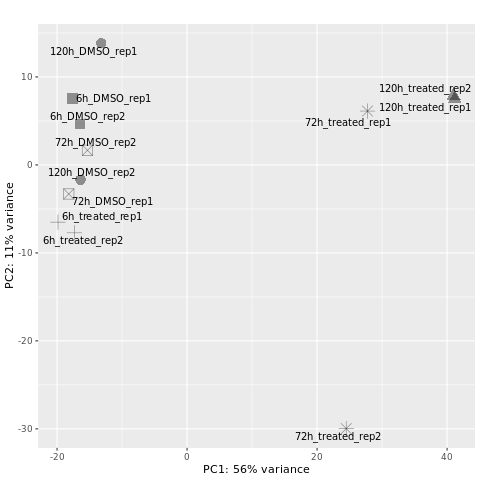

In [13]:
%%R 
dds.pca <- DESeq(dds0, parallel=TRUE)
# results 
vsd <- varianceStabilizingTransformation(dds.pca)

pca = plot_PCA(vsd, colData)
pca

In [14]:
%%R
plot_Save(pca,'plots/PCA_raw')

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



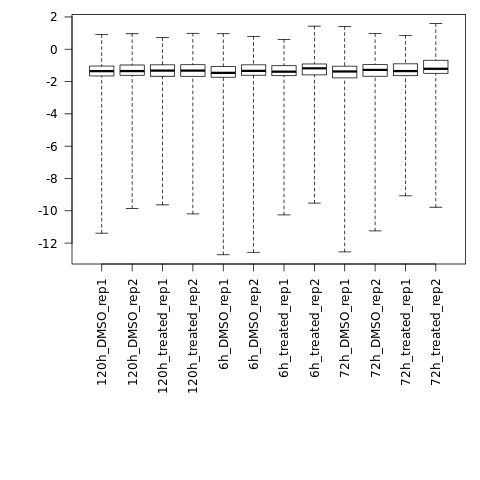

In [15]:
%%R
par(mar=c(15,5,1,1))
boxplot(log10(assays(dds.pca)[["cooks"]]), range=0, las=2)

Filter non-informative genes and outlier sample:

In [16]:
%%R 
# all samples with a count of higher than 10
keep <- rowSums(counts(dds0) > 10) == ncol(dds0)
# at least 3 samples with a count of 10 or higher
# keep <- rowSums(counts(dds) >= 10) >= 3

dds1 <- dds0[keep,-12]
dds1 <- DESeq(dds1) #, parallel=TRUE)
nrow(dds1)

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] 12309


In [17]:
%%R
# results 
vsd <- varianceStabilizingTransformation(dds1)
p = plot_PCA(vsd, colData[-12,], title='Remove sample `72h_treated_rep2`')

Create seprate PCAs

In [18]:
%%R 
dds1 <- DESeqDataSetFromTximport(txi, colData, ~time)

U = grep('DMSO',    colnames(dds0), value=1)
T = grep('treated', colnames(dds0), value=1)[-6]

# subset
dds.U = dds1[keep, U]
# make object for the PCA
dds.pcaU <- DESeq(dds.U) #, parallel=TRUE)
vsd.U <- varianceStabilizingTransformation(dds.pcaU)
# plot it 
p.U = plot_PCA(vsd.U, colData[U,], gr=c('time'), title='Non-treated')


# subset
dds.T = dds1[keep, T]
# make object for the PCA
dds.pcaT <- DESeq(dds.T) #, parallel=TRUE)
vsd.T <- varianceStabilizingTransformation(dds.pcaT)
# plot it 
p.T = plot_PCA(vsd.T, colData[T,], gr=c('time'), title='Treated')

R[write to console]: using counts and average transcript lengths from tximport

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationsh

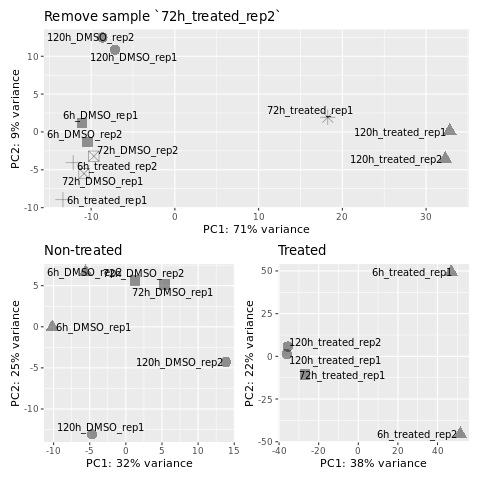

In [19]:
%%R
p / (p.U + p.T) 

In [20]:
%%R
plot_Save(p / (p.U + p.T), 'plots/PCA_filtered')

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



In [21]:
# %%bash
# echo '## PCA' >> README.md
# echo '<img src=plots/plots/PCA_filtered.png style="width:600px">' >> README.md

# Differential expression analysis
I'm doing differential expression analysis for treated samples vs. untreated at 6h, 72h and 120h. 

In [52]:
%%R
plot_Volcano <- function(res, lfc.cutoff  = 1,pval.cutoff = 0.05, title='', x_min=-20,x_max=20){
    res$sig <- as.factor(res$pvalue < pval.cutoff & abs(res$log2FoldChange) > lfc.cutoff)
    relevel(res$sig, ref=TRUE)
    vol = res %>% ggplot(
        aes(x=log2FoldChange, y=-log10(pvalue), colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
            xlim(c(x_min,x_max)) +
    #         ylim(c(0,11)) +
            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "red")) +
            theme_bw() + 
            theme(legend.position="none") +
            ggtitle (title) + 
            geom_text_repel(
                data = subset(res[order(res$pvalue),], sig == TRUE)[1:7,],
                aes(label = name),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            )
     return (vol)
} 

write_Result <- function(res, name_it, col=FALSE, row=FALSE){
    write.table(res,name_it, sep="\t", quote=FALSE, col.names=col, row.names=row)
}

In [59]:
%%R
ann_Result <- function(res){
    return (
        res %>% data.frame %>% 
        add_column(name=gene2name[rownames(res),]) %>%
        add_column(ensembl=rownames(res) %>% substr(0, 15))
    )
}

In [23]:
%%R
plot_gene_counts <- function (dds, gene_id,gene_name){
    fiss <- plotCounts(dds, gene_id, 
                       intgroup = c("cond",'time'), returnData = TRUE)
    fiss$time <- as.character(fiss$time)
    p <- ggplot(fiss,
      aes(x = cond, y = count, color = time, group = time)) + 
      geom_point() + stat_summary(fun.y=mean, geom="line") +
      scale_y_log10() + 
      theme_bw() + 
      ggtitle(gene_name)
    
    return (p)
}

### First scenario
Time included as factor variable. 

We make two different `dds` object one with with no `cond:time` interaction term and the other one with the interaction term (**ANOVA-like comparison**). 

<!-- Then, I'm replacing results from first object to the secound one for genes with adjust p-values (padj) > 0.05. Hossien Asgharian told me these genes has more accurate estimation from the model with no interaction term.  -->

https://bioconductor.org/packages/release/workflows/vignettes/RNAseq123/inst/doc/designmatrices.html#design-matrices-with-and-without-intercept-term

In [84]:
%%R 
levels(colData$cond)

[1] "DMSO"    "treated"


In [158]:
%%R 
model.matrix(~0+cond*time, colData)

                  condDMSO condtreated time6h time72h condtreated:time6h
120h_DMSO_rep1           1           0      0       0                  0
120h_DMSO_rep2           1           0      0       0                  0
120h_treated_rep1        0           1      0       0                  0
120h_treated_rep2        0           1      0       0                  0
6h_DMSO_rep1             1           0      1       0                  0
6h_DMSO_rep2             1           0      1       0                  0
6h_treated_rep1          0           1      1       0                  1
6h_treated_rep2          0           1      1       0                  1
72h_DMSO_rep1            1           0      0       1                  0
72h_DMSO_rep2            1           0      0       1                  0
72h_treated_rep1         0           1      0       1                  0
72h_treated_rep2         0           1      0       1                  0
                  condtreated:time72h
120h_DMSO_rep

In [157]:
%%R 
dds <- DESeqDataSetFromTximport(txi.gene, colData, ~0 + cond + time + cond:time)

dds$time <- relevel(dds$time, ref="6h")
dds$cond <- relevel(dds$cond, ref="DMSO")

# Annova test
dds <- DESeq(dds, test="LRT", reduced=~1) #, parallel=TRUE)
ncu <- counts(dds, normalized=TRUE) 

R[write to console]: using counts and average transcript lengths from tximport

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [159]:
%%R
resultsNames(dds)

[1] "condDMSO"             "condtreated"          "time120h"            
[4] "time72h"              "condtreated.time120h" "condtreated.time72h" 


In [160]:
%%R 
write.table(
    ncu %>% data.frame %>% add_column(name = gene2name[rownames(ncu),]),
    'hl60_exp_deseq2_norm.txt', sep="\t", quote=FALSE, 
    col.names=do.call(c, list(levels(colData$sample_id), c('name')))
)

In [179]:
# %%R
# dds_ind <- DESeqDataSetFromTximport(txi.gene, colData, ~0+cond + time)

# dds_ind$time <- relevel(dds_ind$time, ref="6h")
# dds_ind$cond <- relevel(dds_ind$cond, ref="DMSO")


# dds_ind <- DESeq(dds_ind, test="LRT", reduced=~1) #, parallel=TRUE)

In [178]:
# %%R
# resultsNames(dds_ind)

In [180]:
# %%R
# # no interaction
# res.ind = results(dds_ind,contrast=list("condDMSO","condtreated"),listValues=c(1,-1)) %>% ann_Result

In [183]:
%%R
# contrast design: treatment at 6h vs dmso at 6h
res.6h  = results(dds, contrast=list("condtreated","condDMSO"),listValues=c(1,-1)) %>% ann_Result

vol.6h  = plot_Volcano(res.6h, title='Treated time: 6 hours')

In [184]:
%%R
# contrast design: treatment at 72h vs dmso at 72h
res.72h = results(dds, contrast=list(c('condtreated', 'condtreated.time72h'),c('condDMSO')),listValues=c(1,-1)) %>% ann_Result

vol.72h = plot_Volcano(res.72h, title='Treated time: 72 hours')

In [185]:
%%R
# contrast design: treatment at 120h vs dmso at 120h
res.120h = results(dds, contrast=list(c('condtreated', 'condtreated.time120h'),c('condDMSO')),listValues=c(1,-1)) %>% ann_Result

vol.120h= plot_Volcano(res.120h, title='Treated time: 120 hours')

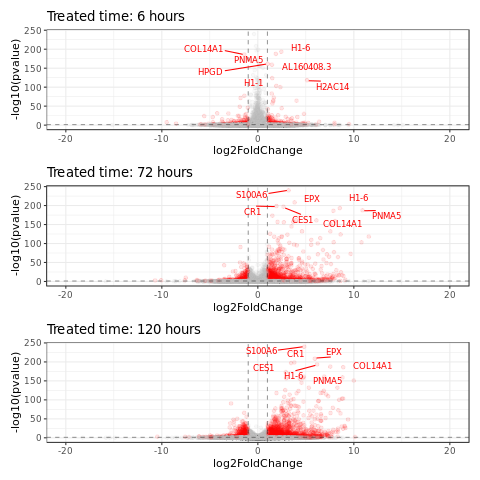

In [186]:
%%R
vol = vol.6h / vol.72h / vol.120h
vol

In [187]:
%%R
plot_Save(vol, 'plots/Volcano_plot')

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



In [188]:
# %%bash
# echo '## Volcano plot' >> README.md
# echo '<img src=plots/plots/Volcano_plot.png style="width:600px">' >> README.md

In [189]:
%%R    
df = data.frame(
    'gene_id'=rownames(dds), 'gene_name'= gene2name[rownames(dds),],
    'log2FC_6h' = res.6h$log2FoldChange,'pval_6h'= res.6h$pval,
    'log2FC_72h' = res.72h$log2FoldChange,'pval_72h'= res.72h$pval,
    'log2FC_120h'  = res.120h$log2FoldChange,'pval_120h'= res.120h$pval) %>% remove_rownames
    
df = df[order(df$log2FC_72h),] %>% remove_rownames
    
write_Result(df, 'hl60_delta_exp_table.txt', col=TRUE)

In [190]:
%%R 
df_sig = df %>% 
    filter ((pval_6h < 0.05 | pval_72h < 0.05 | pval_120h < 0.05) & 
            (abs(log2FC_6h) > 2 | abs(log2FC_72h) > 2 | abs(log2FC_120h) > 2)) %>% 
    remove_rownames %>% column_to_rownames('gene_id') 

## Check the direction of logFC 

In [191]:
%%R 
head(df_sig)

                    gene_name log2FC_6h      pval_6h log2FC_72h     pval_72h
ENSG00000256206.2  AC018523.2 9.5014911 1.510688e-03 -10.699226 1.510688e-03
ENSG00000205609.13     EIF3CL 4.7709525 9.373767e-04 -10.068521 9.373767e-04
ENSG00000234431.2  AC007283.1 0.1086207 1.128725e-03  -7.595344 1.128725e-03
ENSG00000250506.7        CDK3 0.3020142 8.177233e-11  -7.507771 8.177233e-11
ENSG00000204778.4      CBWD4P 4.4111625 1.612892e-02  -6.392439 1.612892e-02
ENSG00000243789.11      JMJD7 2.1825039 1.441457e-04  -6.350021 1.441457e-04
                    log2FC_120h    pval_120h
ENSG00000256206.2   -3.11549349 1.510688e-03
ENSG00000205609.13 -10.47264081 9.373767e-04
ENSG00000234431.2   -0.55555753 1.128725e-03
ENSG00000250506.7   -1.61903080 8.177233e-11
ENSG00000204778.4   -4.23409326 1.612892e-02
ENSG00000243789.11   0.09574719 1.441457e-04


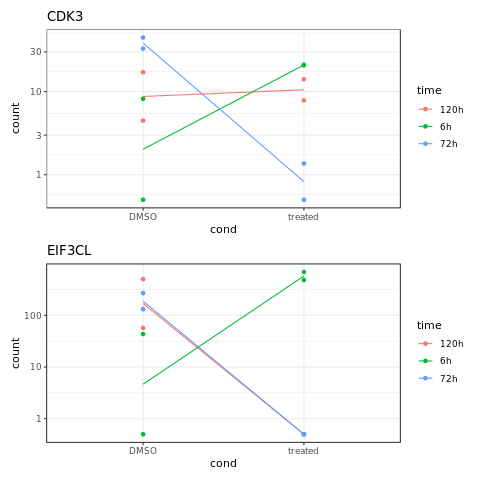

In [193]:
%%R 


gene_names = levels(droplevels(head(df_sig$gene_name)))
gene_ids = rownames(gene2name)[gene2name$gene_name %in% gene_names]


plot_gene_counts(dds,  gene_ids[4],gene_names[4]) /
plot_gene_counts(dds,  gene_ids[5],gene_names[5])

# Heatmap 
## Most variable genes 
Cluster high variant genes over time. 

In [100]:
# %%R 
# library(pheatmap)
# # mostVar Calculate the top n most variable genes in a matrix of gene expression data
# # https://rdrr.io/github/abc-igmm/transcripTools/man/mostVar.html
# mostVar <- function(data, n, i_want_most_var = FALSE) {
#   data.var <- apply(data, 1, stats::var)
#   data[order(data.var, decreasing = i_want_most_var)[1:n],] 
# }

# ncu %>% head 
# # fc <- df[!duplicated(df$gene_name),c('gene_name','log2FC_6h','log2FC_72h','log2FC_120h')] %>% remove_rownames %>% column_to_rownames('gene_name')

# # # scale - Z-Score
# # fc <- data.frame(apply(fc,2,scale, center=TRUE, scale=TRUE), row.names=rownames(fc)) 

# # # filter most variable genes
# # fc = mostVar(fc,30)
# # # Plot heatmap
# # h1 <- pheatmap(fc,cluster_cols = FALSE,angle_col=45)
# # h1

## Clustering 

In [217]:
%%R 
ncu[,c(5:8,1:4,9:12)] %>% head 


                   6h_DMSO_rep1 6h_DMSO_rep2 6h_treated_rep1 6h_treated_rep2
ENSG00000000003.15      7.36705     9.318714        9.269854        8.802836
ENSG00000000005.6       0.00000     0.000000        0.000000        0.000000
ENSG00000000419.12   2513.13800  2500.557736     2402.711568     2100.313086
ENSG00000000457.14    248.88662   315.103261      276.541375      284.694141
ENSG00000000460.17   1164.34746  1264.225534     1006.351313     1096.716566
ENSG00000000938.13    254.70234   235.129580      251.185452      227.320236
                   120h_DMSO_rep1 120h_DMSO_rep2 120h_treated_rep1
ENSG00000000003.15       7.351925       13.55335          15.16106
ENSG00000000005.6        0.000000        0.00000           0.00000
ENSG00000000419.12    1976.335064     2069.49876        1265.46709
ENSG00000000457.14     307.680025      257.39607         319.27148
ENSG00000000460.17     974.239561     1109.45819         847.10648
ENSG00000000938.13     304.080231      239.02603        138

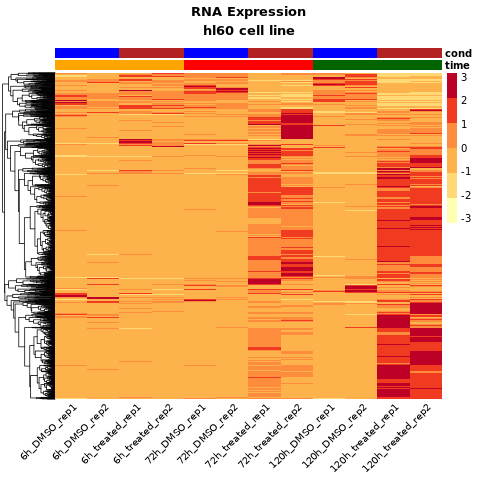

In [219]:
%%R 
library(RColorBrewer)
library(pheatmap)

# Subset normalized counts to significant genes
sig_norm_counts <- ncu[rownames(df_sig),c(5:12,1:4)]

# Choose heatmap color palette
heat_colors <- brewer.pal(n = 6, name = "YlOrRd")

ann_colors = list(
    cond = c('DMSO'="blue", 'treated'="firebrick"),
    time = c('120h'= "darkgreen", '72h'="red", '6h'="orange")
)

# Plot heatmap
h = pheatmap(sig_norm_counts, 
         color = heat_colors, 
         cluster_cols = F, 
         show_rownames = F,
         annotation = select(colData, time, cond), 
         scale = 'row',
         main = 'RNA Expression\nhl60 cell line',
         angle_col= 45,
         annotation_legend=F,
         annotation_colors = ann_colors
            )

In [220]:
%%R 
# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('plots/Heatmap_clustering.pdf', width=7, height=7)
grid::grid.newpage()
grid::grid.draw(h$gtable)
dev.off()

png 
  2 


In [221]:
# %%bash
# echo '## Heatmap clustering' >> README.md
# echo '<img src=plots/plots/Heatmap_clustering.pdf.png style="width:600px">' >> README.md

## Enrichment analysis 

Prepare results for running iPAGE:

In [222]:
%%R 
write_Result(res.6h  [,c('ensembl','log2FoldChange')] %>% remove_rownames, '6h_delta_exp.txt')
write_Result(res.72h [,c('ensembl','log2FoldChange')] %>% remove_rownames, '72h_delta_exp.txt')
write_Result(res.120h[,c('ensembl','log2FoldChange')] %>% remove_rownames, '120h_delta_exp.txt')

In [223]:
# %%bash
# ipage=/rumi/shams/abe/Workflows/my_scripts/ipage_human_ensembl.sh 
# nohup ls *delta_exp.txt | parallel -j18 -k bash $ipage {} &> ipage.out &

In [224]:
# %%bash
# echo '<h1>'Enrichment analysis'<h1>' >> README.md

# declare -a Comp=('6h' '72h' '120h')

# for f in `ls -d /flash/bin/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/human_ensembl*`; do
#     base=`basename "$f"`
#     echo '<table>' >> README.md
#     echo '  <tr>' >> README.md
#     echo '  <h2>'$base'<h2>' >> README.md
#     for C in "${Comp[@]}"; do
#         echo '    <td><img src='${C}'_delta_exp/'${base}'.all.png style="width:600px">' >> README.md
#     done
#     echo '  <tr>' >> README.md
#     echo '<table>' >> README.md
# done

### Second scenario
Time as continues variable

In [23]:
# %%R 
# # meta 
# colData.T <- data.frame(
#     time=c(rep(120,4),rep(6,4),rep(72,4)), 
#     cond=rep(c(rep('DMSO',2), rep('treated',2)),3), 
#     time_cond=paste(hours,treats,sep='_'), 
#     sample_id=colnames(txi$abundance),
#     row.names=colnames(txi$abundance))

# dds.T <- DESeqDataSetFromTximport(txi.gene, colData.T, ~cond + time + cond:time)
# dds.T <- DESeq(dds.T, test="LRT", reduced=~1, parallel=TRUE)

In [24]:
# %%R
# resultsNames(dds.T)

In [25]:
# %%R
# res_cnt_time_T_vs_U = results(dds.T, name='cond_treated_vs_DMSO', parallel=T) %>% 
#     data.frame %>% add_column(name = gene2name[rownames(dds.T),]) %>%
#     add_column(ensembl = rownames(dds.T) %>% substr(0, 15))

# p1 = plot_Volcano(res_cnt_time_T_vs_U, 0.1, title='Time as continuous variable: Treated vs DMSO', 
#                   x_min=-2,x_max=2)

In [56]:
# %%R
# res_cnt_time = results(dds.T, name='condtreated.time', parallel=T) %>% 
#     data.frame %>% add_column(name = gene2name[rownames(dds.T),]) %>%
#     add_column(ensembl = rownames(dds.T) %>% substr(0, 15))

# p2 = plot_Volcano(res_cnt_time, 0.01, title='Time as continuous variable: Condition and time interaction', 
#                   x_min=-0.1,x_max=0.1)

In [26]:
# %%R
# df = data.frame(
#     'gene_id'=rownames(res_cnt_time_T_vs_U), 'gene_name'= res_cnt_time_T_vs_U$name,
#     'baseMean' = res_cnt_time$baseMean,
#     'log2FC_time' = res_cnt_time$log2FoldChange,'log2FC_time'= res_cnt_time$pval,
#     'log2FC_T_vs_U' = res_cnt_time_T_vs_U$log2FoldChange,'pval_T_vs_U'= res_cnt_time_T_vs_U$pval
# )    
# df = df[order(df$log2FC_time),]

# write_Result(df, 'results_time_continuous.txt', col=TRUE)

In [27]:
# %%R
# plot_Save(p1 / p2, 'Volcano_time_continuous')
# p1 / p2

___
## Find transcripts of genes selected for experimental validation 
Hani: 
> can you tell me for the selected genes, which isoforms are the major isoforms?

In [1]:
# %%R 
# valid_genes = gene2name %>% rownames_to_column('GENEID') %>% filter(gene_name%in%c('MTF1', 'MCL1', 'CYLD', 'APLP2'))

# valid_txs = tx2gene %>% filter(GENEID%in%valid_genes$GENEID)

# ddsـtxi <- DESeqDataSetFromTximport(txi, colData, ~cond + time + cond:time)
# nrow(ddsـtxi)

In [2]:
# %%R -o valid_df

# counts(ddsـtxi[valid_txs$TXNAME,], normalized=FALSE) %>% 
#     data.frame %>% 
#     rownames_to_column('transcript_id') -> valid_df
# valid_df %>% 
#     add_column(name=tx2name[valid_df$transcript_id,]) %>% 
#     arrange(desc(X72h_DMSO_rep1)) -> valid_df



In [3]:
# valid_df.set_index('transcript_id').loc[
#     list (valid_df.loc[:,['X72h_DMSO_rep1','X72h_DMSO_rep2','X72h_treated_rep1','X72h_treated_rep2']].min(axis=1) > 300),
#     ['name','X72h_DMSO_rep1','X72h_DMSO_rep2','X72h_treated_rep1','X72h_treated_rep2']
# ]

In [4]:
# %%R 
# ddsـtxi$time <- relevel(ddsـtxi$time, ref="6h")

# # Annova test
# ddsـtxi <- DESeq(ddsـtxi, test="LRT", reduced=~1) #, parallel=TRUE)
# ncu_txi <- counts(ddsـtxi, normalized=TRUE) 
# # write.table(ncu,'hl60_exp_deseq2_norm.txt', sep="\t", quote=FALSE, col.names=colData$sample_id)

In [5]:
# %%R
# resultsNames(ddsـtxi)

In [6]:
# %%R 
# dds_valid_txs = ddsـtxi[valid_txs$TXNAME,]

In [7]:
# %%R 
# tx2name %>% rownames_to_column('transcript_id') %>% filter(transcript_id %in% rownames(dds_valid_txs) )


In [9]:
# %%R 
# get_Result_txi <- function(dds, design){
#     res = results(dds, contrast=design, parallel=TRUE)  %>%
#         data.frame %>% 
#         add_column(name=tx2name[rownames(dds),])
                
#     return (res)
# }

# # contrast design: treatment at 72h vs dmso at 72h
# res_txi.72h = get_Result_txi(ddsـtxi, list('cond_treated_vs_DMSO', 'condtreated.time72h')) 
# res_valid_txi.72h = get_Result_txi(dds_valid_txs, list('cond_treated_vs_DMSO', 'condtreated.time72h')) 

# # # contrast design: treatment at 6h vs dmso at 6h
# # res.6h  = get_Result(ddsـtxi, list('cond_treated_vs_DMSO'))
# # # contrast design: treatment at 120h vs dmso at 120h
# # res.120h= get_Result(dds, list('cond_treated_vs_DMSO', 'condtreated.time120h'))

In [11]:
# %%R 

# lfc.cutoff  = 0; pval.cutoff = 1; 
# title='Treated time: 72 hours'; 
# x_min=-20;x_max=20;y_max=4
# res = res_valid_txi.72h

# res$sig <- as.factor(res$pvalue < pval.cutoff & abs(res$log2FoldChange) > lfc.cutoff)
# res$sig <- relevel(res$sig, ref=TRUE)

# vol = res %>% ggplot(
#     aes(x=log2FoldChange, y=-log10(pvalue), colour=sig, fill=sig)) +
#     geom_point(aes(color = sig),alpha = 1/10) +
#     xlim(c(x_min,x_max)) +
#     ylim(c(0,y_max)) +
#         geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
#         geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
#         geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
#         scale_color_manual(values = c("grey", "red")) +
#         theme_bw() + 
#         theme(legend.position="none") +
#         ggtitle (title) + 
#         geom_text_repel(
#             data = subset(res[order(res$pvalue),], sig == TRUE),#[1:10,],
#             aes(label = name),
#             size = 2,
#             box.padding = unit(0.35, "lines"),
#             point.padding = unit(0.3, "lines")
#         )
# plot_Save(vol, 'plots/Volcano_plot_validation_genes')
# vol


In [46]:
%%R
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] patchwork_1.0.0             DESeq2_1.20.0              
 [3] SummarizedExperiment_1.10.1 DelayedArray_0.6.6         
 [5] BiocParallel_1.14.2         matrixStats_0.55.0         
 [7] ggrepel_0.8.1               forcats_0.4.0              
 [9] stringr_1.4.0    